In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
sys.path.insert(0,"/analysis/fabiane/phd/patch_individual_filters/")

In [4]:
import os
import glob
import h5py
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch

from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity, auc_score
from nitorch.utils import count_parameters

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from pif import PatchIndividualFilters3D

In [6]:
torch.__version__

'1.0.0'

In [7]:
gpu = 4
multi_gpus = None #[0, 1, 2]
b = 12
zero_one_normalize = False
zoom = 0.525

dtype = np.float64

In [8]:
# load mask
mask = None

In [9]:
train_h5 = h5py.File("/ritter/share/data/ADNI_HDF5/Splits_Eitel/train_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
val_h5 = h5py.File("/ritter/share/data/ADNI_HDF5/Splits_Eitel/val_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
holdout_h5 = h5py.File("/ritter/share/data/ADNI_HDF5/Splits_Eitel/holdout_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')

In [10]:
X_train, y_train = train_h5['X'], train_h5['y']
X_val, y_val = val_h5['X'], val_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [11]:
new_ind, _ = train_test_split(np.arange(len(X_train)), train_size=0.2, random_state=42)

/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [12]:
print(len(new_ind))

139


In [13]:
train_sampler = SubsetRandomSampler(new_ind)

In [14]:
# define dataset

In [15]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [16]:
if zero_one_normalize:
    intensity = IntensityRescale() 
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose([SagittalFlip(), intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([SagittalFlip(), intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
else:
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose([SagittalFlip(), ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([SagittalFlip(), ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

torch.Size([1, 96, 114, 96])


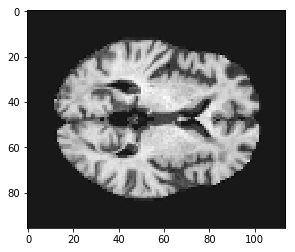

In [17]:
sample = adni_data_test[-1]
img = sample["image"]
print(img.shape)
plt.imshow(img[0][:,:,40], cmap='gray')

# Define the classifier

In [18]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)

        self.pif = PatchIndividualFilters3D([10,13,10],
                                            filter_shape=(3,3,3),
                                            patch_shape=(5,5,5),
                                            num_local_filter_in=64,
                                            num_local_filter_out=3,
                                            overlap=1,
                                            reassemble=False,
                                            debug=False)

        self.classifier_scratch = nn.Sequential(
            nn.Linear(1134, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)    
        h = F.elu(self.pif(x))
    
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [19]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [20]:
print(net)

SixtyFourNet(
  (drop): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_4): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pif): PatchIndividualFilters3D(
    (conv_0): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_1): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_2): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_3): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_4): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_5): Conv3d(64, 3, kernel_size=(3, 3, 

In [21]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 519979


# Training

In [64]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    for trial in range(10):
        print("Starting trial {}".format(trial))

        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

        train_loader = DataLoader(
            adni_data_train, batch_size=b, num_workers=4, sampler=train_sampler
        )
        val_loader = DataLoader(
            adni_data_val, batch_size=1, num_workers=1, shuffle=True
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        print(img.shape)
        print(len(train_loader))
        plt.imshow(img.squeeze()[:,:,48], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=10,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric]))
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric.__name__]))

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    return fold_metric, models


In [22]:
num_epochs = 200
min_iters = 3
ignore_epochs = 25
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy, auc_score]

In [23]:
r = 1

In [24]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/ADNI/20_percent/experiment/"
callbacks = [EarlyStopping(patience=12, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

Starting trial 0
torch.Size([1, 96, 114, 96])
12


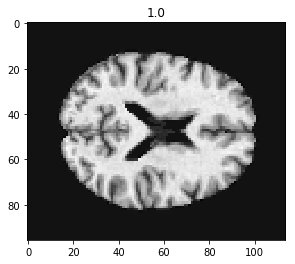

[0,    10] loss: 0.68821
Time elapsed: 0h:0m:4s
train accuracy_score: 56.12 %
train balanced_accuracy: 49.13 %
train auc_score: 49.13 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.734523
[1,    10] loss: 0.68839
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.716436
[2,    10] loss: 0.68690
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.709776
[3,    10] loss: 0.67705
Time elapsed: 0h:0m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.748048
[4,    10] loss: 0.68267
Time elapsed: 0h:0m:30s


val accuracy_score: 75.00 %
val balanced_accuracy: 77.92 %
val auc_score: 77.92 %
Val loss: 0.580992
[35,    10] loss: 0.63991
Time elapsed: 0h:3m:55s
train accuracy_score: 70.50 %
train balanced_accuracy: 65.63 %
train auc_score: 65.63 %
val accuracy_score: 81.00 %
val balanced_accuracy: 76.25 %
val auc_score: 76.25 %
Val loss: 0.545103
[36,    10] loss: 0.68646
Time elapsed: 0h:4m:1s
train accuracy_score: 58.27 %
train balanced_accuracy: 59.06 %
train auc_score: 59.06 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.789362
[37,    10] loss: 0.60777
Time elapsed: 0h:4m:8s
train accuracy_score: 64.75 %
train balanced_accuracy: 58.49 %
train auc_score: 58.49 %
val accuracy_score: 78.00 %
val balanced_accuracy: 78.75 %
val auc_score: 78.75 %
Val loss: 0.554463
[38,    10] loss: 0.59195
Time elapsed: 0h:4m:14s
train accuracy_score: 68.35 %
train balanced_accuracy: 66.96 %
train auc_score: 66.96 %
val accuracy_score: 67.00 %
val balanced_accur

[69,    10] loss: 0.22158
Time elapsed: 0h:7m:42s
train accuracy_score: 92.09 %
train balanced_accuracy: 91.74 %
train auc_score: 91.74 %
val accuracy_score: 84.00 %
val balanced_accuracy: 84.58 %
val auc_score: 84.58 %
Val loss: 0.380753
[70,    10] loss: 0.14437
Time elapsed: 0h:7m:49s
train accuracy_score: 94.24 %
train balanced_accuracy: 93.84 %
train auc_score: 93.84 %
val accuracy_score: 81.00 %
val balanced_accuracy: 80.83 %
val auc_score: 80.83 %
Val loss: 0.394722
[71,    10] loss: 0.18559
Time elapsed: 0h:7m:56s
train accuracy_score: 92.81 %
train balanced_accuracy: 92.85 %
train auc_score: 92.85 %
val accuracy_score: 83.00 %
val balanced_accuracy: 82.08 %
val auc_score: 82.08 %
Val loss: 0.384095
[72,    10] loss: 0.13314
Time elapsed: 0h:8m:2s
train accuracy_score: 97.84 %
train balanced_accuracy: 97.90 %
train auc_score: 97.90 %
val accuracy_score: 77.00 %
val balanced_accuracy: 80.00 %
val auc_score: 80.00 %
Val loss: 0.672073
[73,    10] loss: 0.12649
Time elapsed: 0h:8m

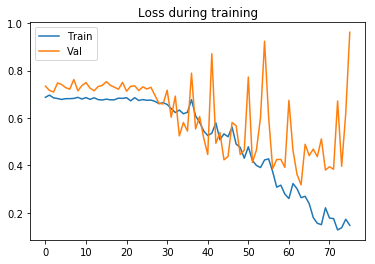

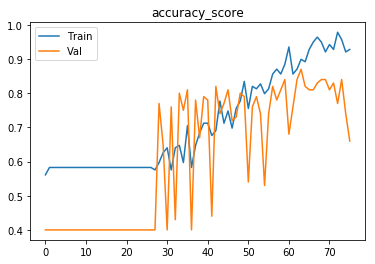

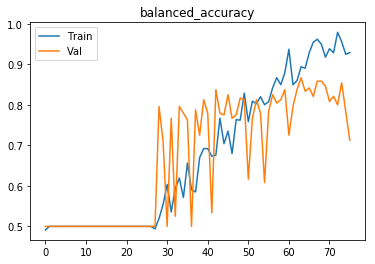

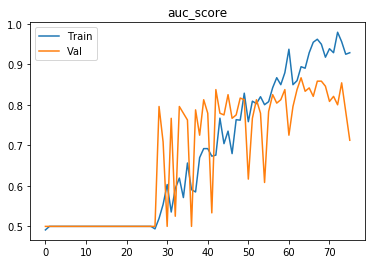

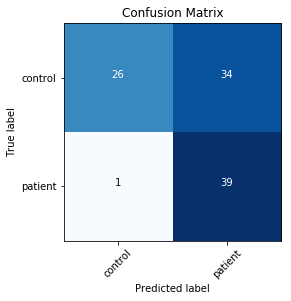

Starting trial 1
torch.Size([1, 96, 114, 96])
12


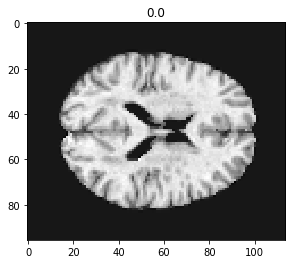

[0,    10] loss: 0.69572
Time elapsed: 0h:0m:4s
train accuracy_score: 51.80 %
train balanced_accuracy: 46.65 %
train auc_score: 46.65 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.749056
[1,    10] loss: 0.69145
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.709350
[2,    10] loss: 0.67912
Time elapsed: 0h:0m:18s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.728417
[3,    10] loss: 0.67677
Time elapsed: 0h:0m:25s
train accuracy_score: 58.99 %
train balanced_accuracy: 50.86 %
train auc_score: 50.86 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.732965
[4,    10] loss: 0.68205
Time elapsed: 0h:0m:31s


val accuracy_score: 81.00 %
val balanced_accuracy: 82.50 %
val auc_score: 82.50 %
Val loss: 0.603198
[35,    10] loss: 0.65008
Time elapsed: 0h:4m:0s
train accuracy_score: 58.27 %
train balanced_accuracy: 54.90 %
train auc_score: 54.90 %
val accuracy_score: 43.00 %
val balanced_accuracy: 52.50 %
val auc_score: 52.50 %
Val loss: 0.685613
[36,    10] loss: 0.60162
Time elapsed: 0h:4m:6s
train accuracy_score: 66.91 %
train balanced_accuracy: 64.02 %
train auc_score: 64.02 %
val accuracy_score: 75.00 %
val balanced_accuracy: 77.92 %
val auc_score: 77.92 %
Val loss: 0.585508
[37,    10] loss: 0.61458
Time elapsed: 0h:4m:13s
train accuracy_score: 64.03 %
train balanced_accuracy: 60.08 %
train auc_score: 60.08 %
val accuracy_score: 80.00 %
val balanced_accuracy: 79.17 %
val auc_score: 79.17 %
Val loss: 0.505748
[38,    10] loss: 0.55463
Time elapsed: 0h:4m:20s
train accuracy_score: 65.47 %
train balanced_accuracy: 62.54 %
train auc_score: 62.54 %
val accuracy_score: 85.00 %
val balanced_accur

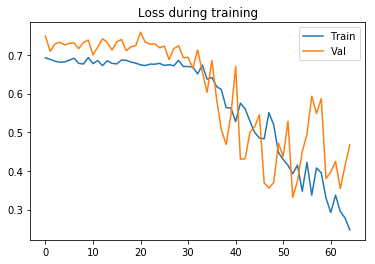

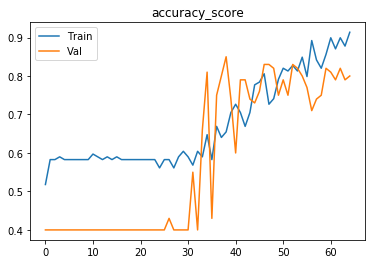

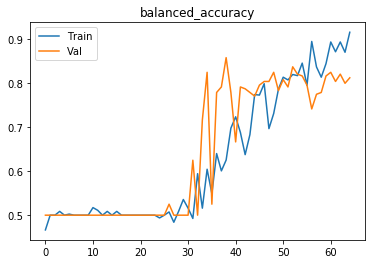

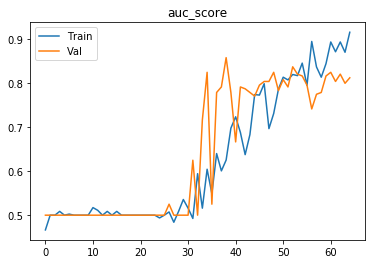

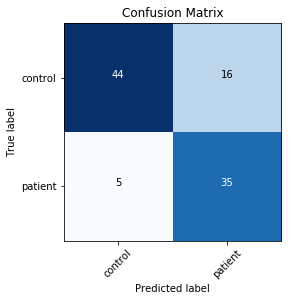

Starting trial 2
torch.Size([1, 96, 114, 96])
12


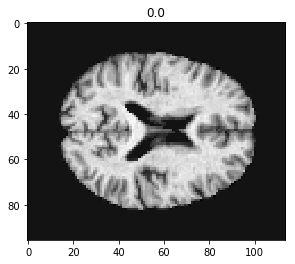

[0,    10] loss: 0.69106
Time elapsed: 0h:0m:4s
train accuracy_score: 57.55 %
train balanced_accuracy: 49.38 %
train auc_score: 49.38 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.759255
[1,    10] loss: 0.68366
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.723970
[2,    10] loss: 0.68569
Time elapsed: 0h:0m:18s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.723679
[3,    10] loss: 0.69746
Time elapsed: 0h:0m:24s
train accuracy_score: 45.32 %
train balanced_accuracy: 41.34 %
train auc_score: 41.34 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.703304
[4,    10] loss: 0.68520
Time elapsed: 0h:0m:31s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.750898
[35,    10] loss: 0.68360
Time elapsed: 0h:4m:0s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.725033
[36,    10] loss: 0.67065
Time elapsed: 0h:4m:7s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.749532
[37,    10] loss: 0.67565
Time elapsed: 0h:4m:14s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.717393
[38,    10] loss: 0.67081
Time elapsed: 0h:4m:20s
train accuracy_score: 58.99 %
train balanced_accuracy: 50.86 %
train auc_score: 50.86 %
val accuracy_score: 40.00 %
val balanced_accur

[69,    10] loss: 0.39047
Time elapsed: 0h:7m:50s
train accuracy_score: 83.45 %
train balanced_accuracy: 82.87 %
train auc_score: 82.87 %
val accuracy_score: 80.00 %
val balanced_accuracy: 82.08 %
val auc_score: 82.08 %
Val loss: 0.464237
[70,    10] loss: 0.38898
Time elapsed: 0h:7m:57s
train accuracy_score: 85.61 %
train balanced_accuracy: 85.45 %
train auc_score: 85.45 %
val accuracy_score: 77.00 %
val balanced_accuracy: 80.00 %
val auc_score: 80.00 %
Val loss: 0.538220
[71,    10] loss: 0.35276
Time elapsed: 0h:8m:3s
train accuracy_score: 87.05 %
train balanced_accuracy: 86.44 %
train auc_score: 86.44 %
val accuracy_score: 77.00 %
val balanced_accuracy: 79.17 %
val auc_score: 79.17 %
Val loss: 0.457843
[72,    10] loss: 0.37278
Time elapsed: 0h:8m:10s
train accuracy_score: 79.86 %
train balanced_accuracy: 79.53 %
train auc_score: 79.53 %
val accuracy_score: 78.00 %
val balanced_accuracy: 81.25 %
val auc_score: 81.25 %
Val loss: 0.566021
[73,    10] loss: 0.32293
Time elapsed: 0h:8m

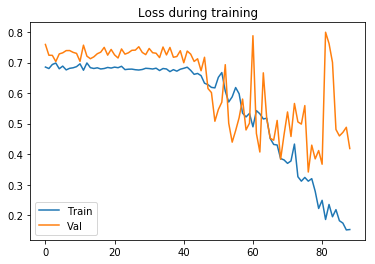

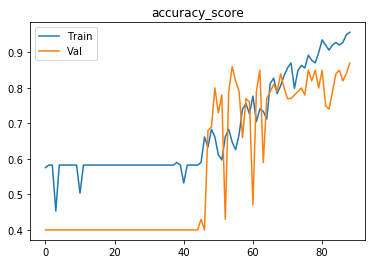

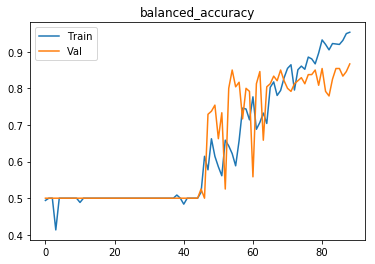

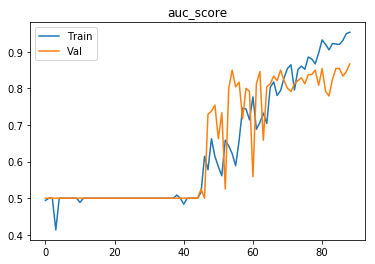

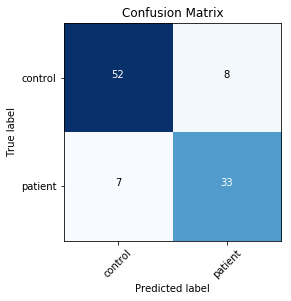

Starting trial 3
torch.Size([1, 96, 114, 96])
12


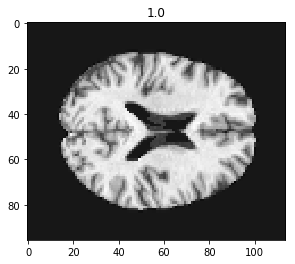

[0,    10] loss: 0.69240
Time elapsed: 0h:0m:4s
train accuracy_score: 51.08 %
train balanced_accuracy: 44.81 %
train auc_score: 44.81 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.717699
[1,    10] loss: 0.68890
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.724174
[2,    10] loss: 0.68540
Time elapsed: 0h:0m:18s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.736523
[3,    10] loss: 0.68196
Time elapsed: 0h:0m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.729166
[4,    10] loss: 0.69075
Time elapsed: 0h:0m:31s


val accuracy_score: 84.00 %
val balanced_accuracy: 80.83 %
val auc_score: 80.83 %
Val loss: 0.525773
[35,    10] loss: 0.61404
Time elapsed: 0h:4m:1s
train accuracy_score: 64.75 %
train balanced_accuracy: 63.88 %
train auc_score: 63.88 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 1.000448
[36,    10] loss: 0.59905
Time elapsed: 0h:4m:7s
train accuracy_score: 66.91 %
train balanced_accuracy: 63.53 %
train auc_score: 63.53 %
val accuracy_score: 43.00 %
val balanced_accuracy: 52.50 %
val auc_score: 52.50 %
Val loss: 0.706852
[37,    10] loss: 0.59804
Time elapsed: 0h:4m:14s
train accuracy_score: 64.75 %
train balanced_accuracy: 60.94 %
train auc_score: 60.94 %
val accuracy_score: 72.00 %
val balanced_accuracy: 75.00 %
val auc_score: 75.00 %
Val loss: 0.563348
[38,    10] loss: 0.58328
Time elapsed: 0h:4m:21s
train accuracy_score: 71.94 %
train balanced_accuracy: 72.74 %
train auc_score: 72.74 %
val accuracy_score: 56.00 %
val balanced_accur

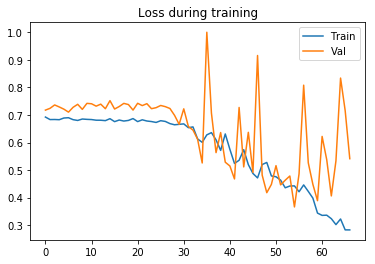

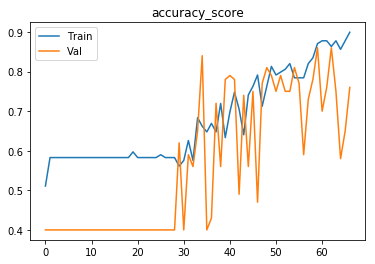

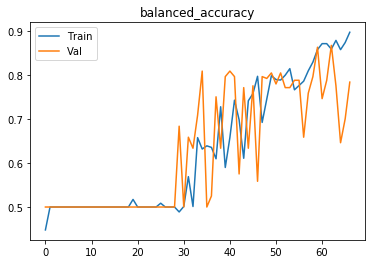

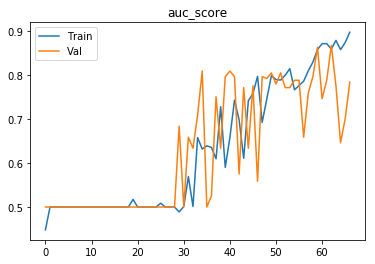

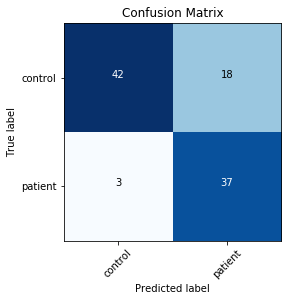

Starting trial 4
torch.Size([1, 96, 114, 96])
12


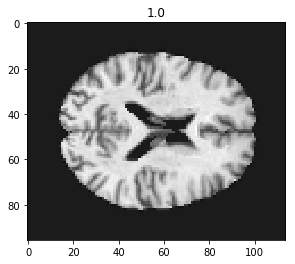

[0,    10] loss: 0.68593
Time elapsed: 0h:0m:4s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.743333
[1,    10] loss: 0.69343
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.740743
[2,    10] loss: 0.67785
Time elapsed: 0h:0m:18s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.729469
[3,    10] loss: 0.68217
Time elapsed: 0h:0m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.747512
[4,    10] loss: 0.68524
Time elapsed: 0h:0m:31s


val accuracy_score: 47.00 %
val balanced_accuracy: 55.83 %
val auc_score: 55.83 %
Val loss: 0.648503
[35,    10] loss: 0.64131
Time elapsed: 0h:4m:0s
train accuracy_score: 60.43 %
train balanced_accuracy: 57.48 %
train auc_score: 57.48 %
val accuracy_score: 45.00 %
val balanced_accuracy: 54.17 %
val auc_score: 54.17 %
Val loss: 0.656318
[36,    10] loss: 0.56112
Time elapsed: 0h:4m:7s
train accuracy_score: 71.94 %
train balanced_accuracy: 72.25 %
train auc_score: 72.25 %
val accuracy_score: 60.00 %
val balanced_accuracy: 66.67 %
val auc_score: 66.67 %
Val loss: 0.619190
[37,    10] loss: 0.60312
Time elapsed: 0h:4m:13s
train accuracy_score: 67.63 %
train balanced_accuracy: 64.63 %
train auc_score: 64.63 %
val accuracy_score: 75.00 %
val balanced_accuracy: 77.92 %
val auc_score: 77.92 %
Val loss: 0.536841
[38,    10] loss: 0.55374
Time elapsed: 0h:4m:20s
train accuracy_score: 69.06 %
train balanced_accuracy: 65.62 %
train auc_score: 65.62 %
val accuracy_score: 74.00 %
val balanced_accur

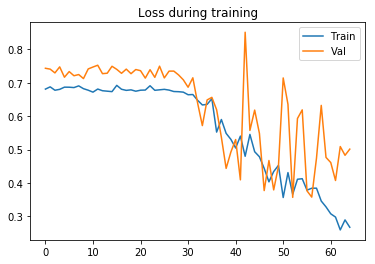

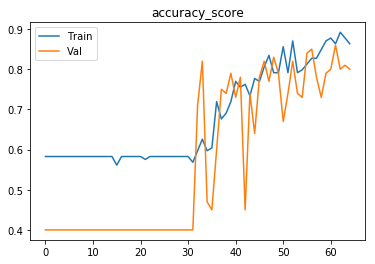

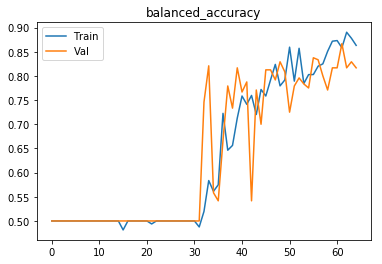

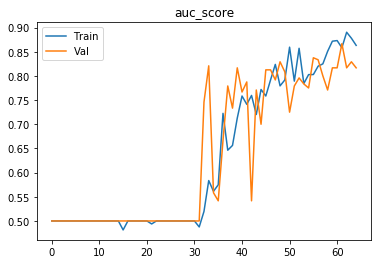

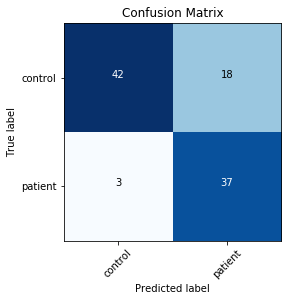

Starting trial 5
torch.Size([1, 96, 114, 96])
12


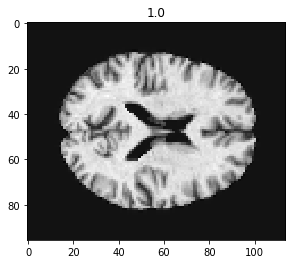

[0,    10] loss: 0.70057
Time elapsed: 0h:0m:4s
train accuracy_score: 53.24 %
train balanced_accuracy: 53.02 %
train auc_score: 53.02 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.730926
[1,    10] loss: 0.68865
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.719488
[2,    10] loss: 0.67862
Time elapsed: 0h:0m:18s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.727048
[3,    10] loss: 0.68195
Time elapsed: 0h:0m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.732313
[4,    10] loss: 0.67853
Time elapsed: 0h:0m:31s


val accuracy_score: 80.00 %
val balanced_accuracy: 82.50 %
val auc_score: 82.50 %
Val loss: 0.495405
[35,    10] loss: 0.53247
Time elapsed: 0h:4m:0s
train accuracy_score: 74.10 %
train balanced_accuracy: 72.39 %
train auc_score: 72.39 %
val accuracy_score: 78.00 %
val balanced_accuracy: 80.42 %
val auc_score: 80.42 %
Val loss: 0.489331
[36,    10] loss: 0.50178
Time elapsed: 0h:4m:7s
train accuracy_score: 78.42 %
train balanced_accuracy: 78.05 %
train auc_score: 78.05 %
val accuracy_score: 58.00 %
val balanced_accuracy: 65.00 %
val auc_score: 65.00 %
Val loss: 0.714363
[37,    10] loss: 0.55673
Time elapsed: 0h:4m:13s
train accuracy_score: 70.50 %
train balanced_accuracy: 68.08 %
train auc_score: 68.08 %
val accuracy_score: 78.00 %
val balanced_accuracy: 79.17 %
val auc_score: 79.17 %
Val loss: 0.436749
[38,    10] loss: 0.52756
Time elapsed: 0h:4m:20s
train accuracy_score: 74.10 %
train balanced_accuracy: 71.66 %
train auc_score: 71.66 %
val accuracy_score: 80.00 %
val balanced_accur

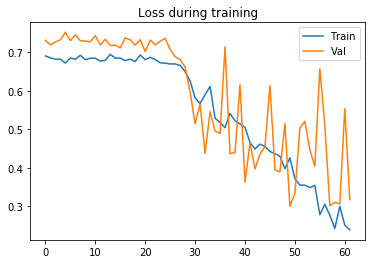

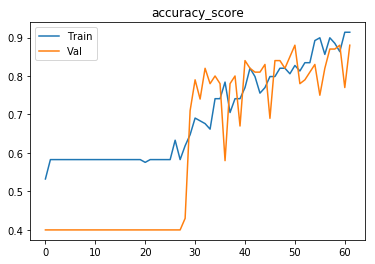

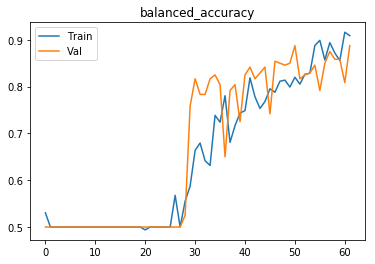

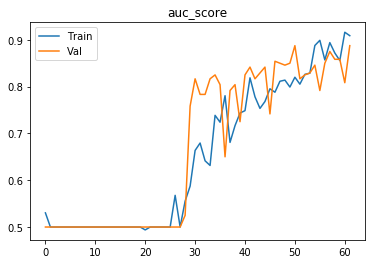

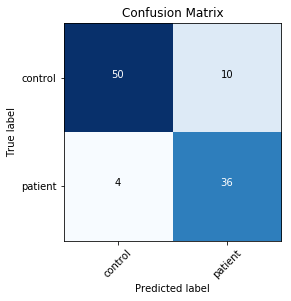

Starting trial 6
torch.Size([1, 96, 114, 96])
12


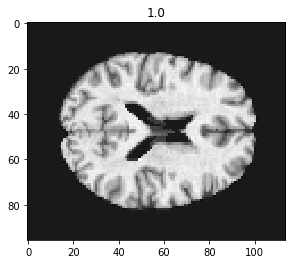

[0,    10] loss: 0.69114
Time elapsed: 0h:0m:4s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.724347
[1,    10] loss: 0.67685
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.721620
[2,    10] loss: 0.68770
Time elapsed: 0h:0m:18s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.710552
[3,    10] loss: 0.68681
Time elapsed: 0h:0m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.727089
[4,    10] loss: 0.68796
Time elapsed: 0h:0m:31s


val accuracy_score: 79.00 %
val balanced_accuracy: 81.25 %
val auc_score: 81.25 %
Val loss: 0.484568
[35,    10] loss: 0.56801
Time elapsed: 0h:4m:1s
train accuracy_score: 69.06 %
train balanced_accuracy: 67.58 %
train auc_score: 67.58 %
val accuracy_score: 80.00 %
val balanced_accuracy: 82.08 %
val auc_score: 82.08 %
Val loss: 0.459929
[36,    10] loss: 0.51908
Time elapsed: 0h:4m:8s
train accuracy_score: 72.66 %
train balanced_accuracy: 71.40 %
train auc_score: 71.40 %
val accuracy_score: 71.00 %
val balanced_accuracy: 75.42 %
val auc_score: 75.42 %
Val loss: 0.549108
[37,    10] loss: 0.49001
Time elapsed: 0h:4m:14s
train accuracy_score: 78.42 %
train balanced_accuracy: 77.56 %
train auc_score: 77.56 %
val accuracy_score: 79.00 %
val balanced_accuracy: 81.67 %
val auc_score: 81.67 %
Val loss: 0.473307
[38,    10] loss: 0.52441
Time elapsed: 0h:4m:21s
train accuracy_score: 76.26 %
train balanced_accuracy: 75.96 %
train auc_score: 75.96 %
val accuracy_score: 52.00 %
val balanced_accur

[69,    10] loss: 0.11909
Time elapsed: 0h:7m:50s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.94 %
train auc_score: 94.94 %
val accuracy_score: 84.00 %
val balanced_accuracy: 85.00 %
val auc_score: 85.00 %
Val loss: 0.431033
[70,    10] loss: 0.14120
Time elapsed: 0h:7m:57s
train accuracy_score: 94.24 %
train balanced_accuracy: 94.08 %
train auc_score: 94.08 %
val accuracy_score: 85.00 %
val balanced_accuracy: 83.33 %
val auc_score: 83.33 %
Val loss: 0.376941
[71,    10] loss: 0.15325
Time elapsed: 0h:8m:4s
train accuracy_score: 94.24 %
train balanced_accuracy: 94.33 %
train auc_score: 94.33 %
val accuracy_score: 82.00 %
val balanced_accuracy: 83.33 %
val auc_score: 83.33 %
Val loss: 0.407128
[72,    10] loss: 0.14496
Time elapsed: 0h:8m:11s
train accuracy_score: 92.81 %
train balanced_accuracy: 92.60 %
train auc_score: 92.60 %
val accuracy_score: 84.00 %
val balanced_accuracy: 85.83 %
val auc_score: 85.83 %
Val loss: 0.474208
Early stopping in epoch 73
Total time elapsed

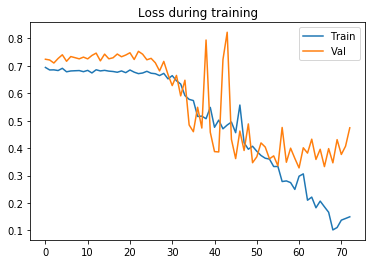

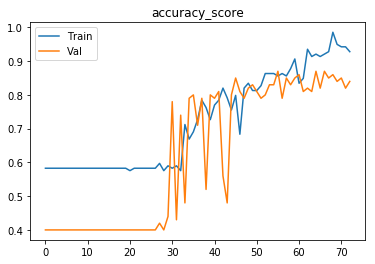

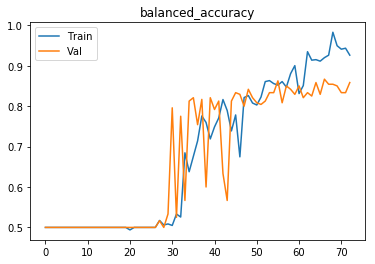

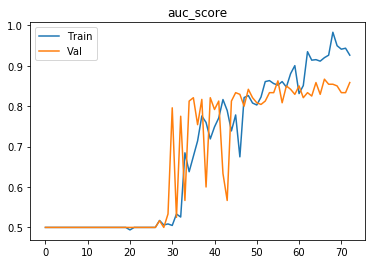

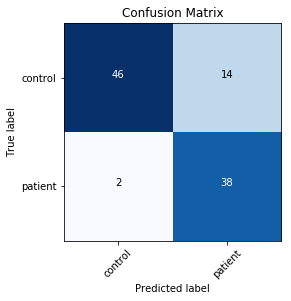

Starting trial 7
torch.Size([1, 96, 114, 96])
12


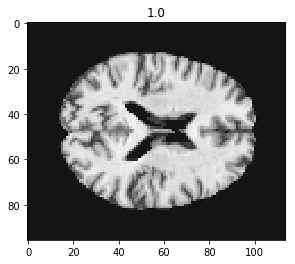

[0,    10] loss: 0.69270
Time elapsed: 0h:0m:4s
train accuracy_score: 53.24 %
train balanced_accuracy: 51.06 %
train auc_score: 51.06 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.716267
[1,    10] loss: 0.68422
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.758502
[2,    10] loss: 0.68839
Time elapsed: 0h:0m:18s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.749454
[3,    10] loss: 0.68228
Time elapsed: 0h:0m:25s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.745185
[4,    10] loss: 0.68340
Time elapsed: 0h:0m:31s


val accuracy_score: 80.00 %
val balanced_accuracy: 80.83 %
val auc_score: 80.83 %
Val loss: 0.438387
[35,    10] loss: 0.55338
Time elapsed: 0h:4m:2s
train accuracy_score: 71.94 %
train balanced_accuracy: 70.30 %
train auc_score: 70.30 %
val accuracy_score: 78.00 %
val balanced_accuracy: 79.58 %
val auc_score: 79.58 %
Val loss: 0.483035
[36,    10] loss: 0.53132
Time elapsed: 0h:4m:9s
train accuracy_score: 76.26 %
train balanced_accuracy: 76.45 %
train auc_score: 76.45 %
val accuracy_score: 43.00 %
val balanced_accuracy: 52.50 %
val auc_score: 52.50 %
Val loss: 0.977169
[37,    10] loss: 0.58634
Time elapsed: 0h:4m:15s
train accuracy_score: 67.63 %
train balanced_accuracy: 64.88 %
train auc_score: 64.88 %
val accuracy_score: 80.00 %
val balanced_accuracy: 79.17 %
val auc_score: 79.17 %
Val loss: 0.420317
[38,    10] loss: 0.52864
Time elapsed: 0h:4m:22s
train accuracy_score: 73.38 %
train balanced_accuracy: 72.02 %
train auc_score: 72.02 %
val accuracy_score: 79.00 %
val balanced_accur

[69,    10] loss: 0.21078
Time elapsed: 0h:7m:51s
train accuracy_score: 89.21 %
train balanced_accuracy: 89.03 %
train auc_score: 89.03 %
val accuracy_score: 79.00 %
val balanced_accuracy: 82.08 %
val auc_score: 82.08 %
Val loss: 0.515865
[70,    10] loss: 0.15594
Time elapsed: 0h:7m:57s
train accuracy_score: 94.96 %
train balanced_accuracy: 95.43 %
train auc_score: 95.43 %
val accuracy_score: 81.00 %
val balanced_accuracy: 83.33 %
val auc_score: 83.33 %
Val loss: 0.508385
[71,    10] loss: 0.19237
Time elapsed: 0h:8m:4s
train accuracy_score: 93.53 %
train balanced_accuracy: 93.71 %
train auc_score: 93.71 %
val accuracy_score: 87.00 %
val balanced_accuracy: 88.75 %
val auc_score: 88.75 %
Val loss: 0.462647
[72,    10] loss: 0.14980
Time elapsed: 0h:8m:11s
train accuracy_score: 95.68 %
train balanced_accuracy: 95.81 %
train auc_score: 95.81 %
val accuracy_score: 87.00 %
val balanced_accuracy: 86.67 %
val auc_score: 86.67 %
Val loss: 0.313114
[73,    10] loss: 0.20463
Time elapsed: 0h:8m

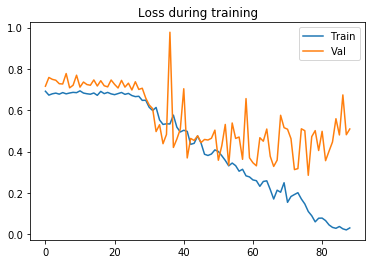

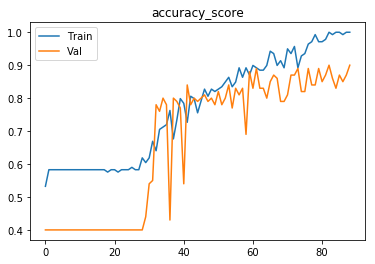

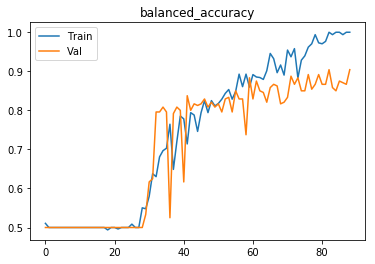

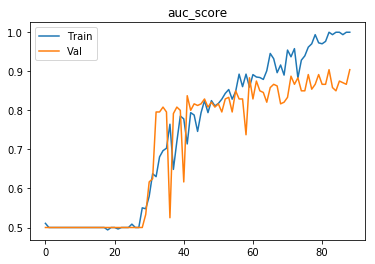

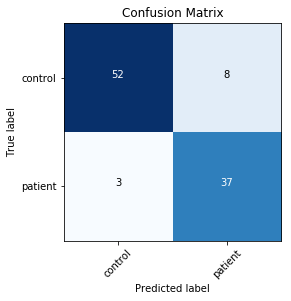

Starting trial 8
torch.Size([1, 96, 114, 96])
12


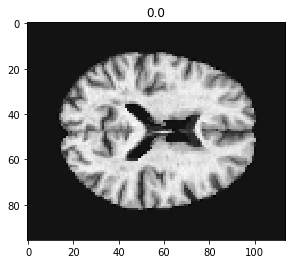

[0,    10] loss: 0.68966
Time elapsed: 0h:0m:4s
train accuracy_score: 56.83 %
train balanced_accuracy: 51.70 %
train auc_score: 51.70 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.734220
[1,    10] loss: 0.68085
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.776368
[2,    10] loss: 0.68443
Time elapsed: 0h:0m:18s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.708513
[3,    10] loss: 0.67663
Time elapsed: 0h:0m:25s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.740080
[4,    10] loss: 0.67748
Time elapsed: 0h:0m:31s


val accuracy_score: 79.00 %
val balanced_accuracy: 80.42 %
val auc_score: 80.42 %
Val loss: 0.522935
[35,    10] loss: 0.57638
Time elapsed: 0h:4m:1s
train accuracy_score: 69.78 %
train balanced_accuracy: 69.42 %
train auc_score: 69.42 %
val accuracy_score: 46.00 %
val balanced_accuracy: 55.00 %
val auc_score: 55.00 %
Val loss: 0.664262
[36,    10] loss: 0.55765
Time elapsed: 0h:4m:8s
train accuracy_score: 67.63 %
train balanced_accuracy: 64.88 %
train auc_score: 64.88 %
val accuracy_score: 80.00 %
val balanced_accuracy: 81.67 %
val auc_score: 81.67 %
Val loss: 0.464223
[37,    10] loss: 0.58182
Time elapsed: 0h:4m:15s
train accuracy_score: 71.94 %
train balanced_accuracy: 70.05 %
train auc_score: 70.05 %
val accuracy_score: 83.00 %
val balanced_accuracy: 83.33 %
val auc_score: 83.33 %
Val loss: 0.440290
[38,    10] loss: 0.55373
Time elapsed: 0h:4m:22s
train accuracy_score: 68.35 %
train balanced_accuracy: 66.23 %
train auc_score: 66.23 %
val accuracy_score: 78.00 %
val balanced_accur

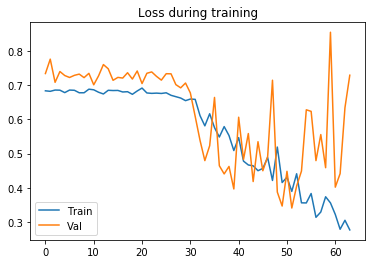

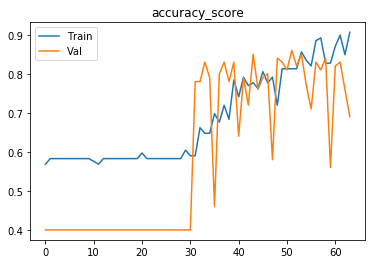

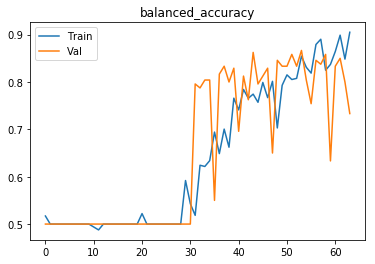

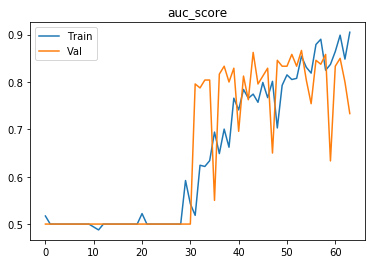

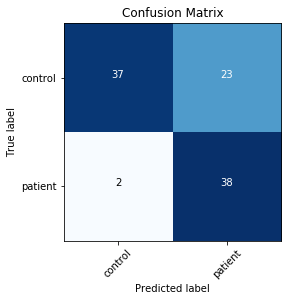

Starting trial 9
torch.Size([1, 96, 114, 96])
12


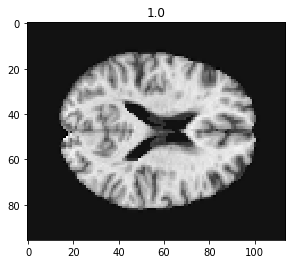

[0,    10] loss: 0.70671
Time elapsed: 0h:0m:4s
train accuracy_score: 56.83 %
train balanced_accuracy: 48.77 %
train auc_score: 48.77 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.718425
[1,    10] loss: 0.68659
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.705048
[2,    10] loss: 0.68483
Time elapsed: 0h:0m:18s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.727715
[3,    10] loss: 0.69042
Time elapsed: 0h:0m:25s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.731579
[4,    10] loss: 0.68644
Time elapsed: 0h:0m:31s


val accuracy_score: 47.00 %
val balanced_accuracy: 55.83 %
val auc_score: 55.83 %
Val loss: 0.652361
[35,    10] loss: 0.63715
Time elapsed: 0h:4m:0s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.24 %
train auc_score: 50.24 %
val accuracy_score: 70.00 %
val balanced_accuracy: 74.58 %
val auc_score: 74.58 %
Val loss: 0.623008
[36,    10] loss: 0.62221
Time elapsed: 0h:4m:7s
train accuracy_score: 68.35 %
train balanced_accuracy: 66.96 %
train auc_score: 66.96 %
val accuracy_score: 65.00 %
val balanced_accuracy: 70.42 %
val auc_score: 70.42 %
Val loss: 0.598471
[37,    10] loss: 0.60479
Time elapsed: 0h:4m:14s
train accuracy_score: 62.59 %
train balanced_accuracy: 58.84 %
train auc_score: 58.84 %
val accuracy_score: 76.00 %
val balanced_accuracy: 77.92 %
val auc_score: 77.92 %
Val loss: 0.521051
[38,    10] loss: 0.54742
Time elapsed: 0h:4m:21s
train accuracy_score: 69.06 %
train balanced_accuracy: 65.62 %
train auc_score: 65.62 %
val accuracy_score: 86.00 %
val balanced_accur

[69,    10] loss: 0.27702
Time elapsed: 0h:7m:50s
train accuracy_score: 88.49 %
train balanced_accuracy: 88.17 %
train auc_score: 88.17 %
val accuracy_score: 82.00 %
val balanced_accuracy: 83.33 %
val auc_score: 83.33 %
Val loss: 0.469754
[70,    10] loss: 0.20043
Time elapsed: 0h:7m:56s
train accuracy_score: 93.53 %
train balanced_accuracy: 93.95 %
train auc_score: 93.95 %
val accuracy_score: 85.00 %
val balanced_accuracy: 86.67 %
val auc_score: 86.67 %
Val loss: 0.491134
[71,    10] loss: 0.13337
Time elapsed: 0h:8m:3s
train accuracy_score: 97.12 %
train balanced_accuracy: 97.29 %
train auc_score: 97.29 %
val accuracy_score: 76.00 %
val balanced_accuracy: 78.33 %
val auc_score: 78.33 %
Val loss: 0.579344
[72,    10] loss: 0.18466
Time elapsed: 0h:8m:10s
train accuracy_score: 93.53 %
train balanced_accuracy: 92.98 %
train auc_score: 92.98 %
val accuracy_score: 88.00 %
val balanced_accuracy: 87.92 %
val auc_score: 87.92 %
Val loss: 0.339078
[73,    10] loss: 0.11922
Time elapsed: 0h:8m

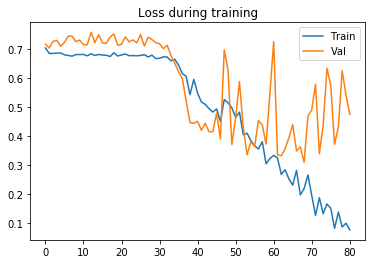

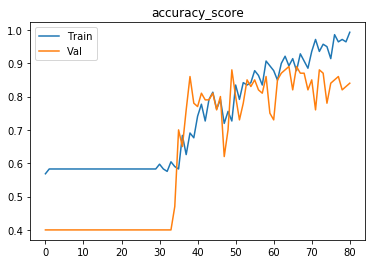

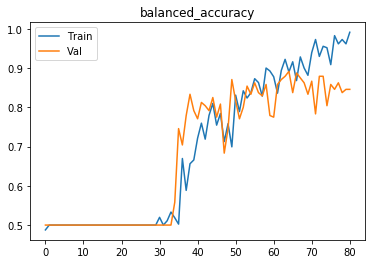

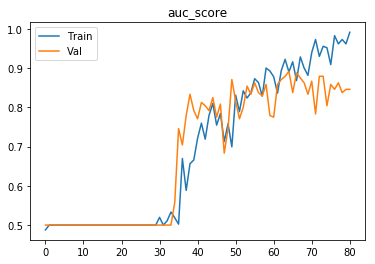

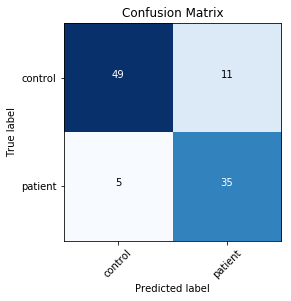

################################
################################
All accuracies: [0.7125, 0.8125, 0.8666666666666667, 0.7833333333333333, 0.8166666666666668, 0.8875, 0.8583333333333334, 0.9041666666666667, 0.7333333333333334, 0.8458333333333333]
Best accuracies mean: 0.8741666666666668 All :[0.8666666666666667, 0.8583333333333334, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8875, 0.8666666666666667, 0.9041666666666667, 0.8666666666666667, 0.8916666666666666]
0.8220833333333333
0.06032464256006825


In [26]:
fold_metric, models = run(net=net, data=adni_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [27]:
print(np.mean(fold_metric))
print(np.std(fold_metric))

0.8220833333333333
0.06032464256006825


In [29]:
5/0

ZeroDivisionError: division by zero

# Start inference

### Using best model checkpoint for inference

In [25]:
test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [26]:
model_dirs = [os.path.join(output_dir,"repeat_{}_cv_fold_{}_BEST_ITERATION.h5".format(r, i)) for i in range(10)]

In [27]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} %".format(np.mean(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} %".format(np.mean(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} %".format(np.mean(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} %".format(np.mean(metrics_df["Specificity"])*100))

Fold 0
Bal. accuracy 78.935 %
ROC AUC Score 82.378 %
Sensitivity 73.333 %
Specificity 84.536 %
Fold 1
Bal. accuracy 80.962 %
ROC AUC Score 90.227 %
Sensitivity 86.667 %
Specificity 75.258 %
Fold 2
Bal. accuracy 78.055 %
ROC AUC Score 89.677 %
Sensitivity 74.667 %
Specificity 81.443 %
Fold 3
Bal. accuracy 76.268 %
ROC AUC Score 86.158 %
Sensitivity 68.000 %
Specificity 84.536 %
Fold 4
Bal. accuracy 78.296 %
ROC AUC Score 85.801 %
Sensitivity 81.333 %
Specificity 75.258 %
Fold 5
Bal. accuracy 77.780 %
ROC AUC Score 86.515 %
Sensitivity 81.333 %
Specificity 74.227 %
Fold 6
Bal. accuracy 78.632 %
ROC AUC Score 88.495 %
Sensitivity 70.667 %
Specificity 86.598 %
Fold 7
Bal. accuracy 78.570 %
ROC AUC Score 90.749 %
Sensitivity 74.667 %
Specificity 82.474 %
Fold 8
Bal. accuracy 78.990 %
ROC AUC Score 90.378 %
Sensitivity 92.000 %
Specificity 65.979 %
Fold 9
Bal. accuracy 80.997 %
ROC AUC Score 87.615 %
Sensitivity 73.333 %
Specificity 88.660 %
######## Final results ########
    Bal Acc   ROC 